In [1]:
import numpy as np
from numpy import sqrt, sin, cos, pi, arccos
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import brute, newton, brentq, root_scalar, minimize
from numpy.linalg import det
from scipy.misc import derivative

# Условие существования энергетической зоны в периодическом потенциале

Условие принадлежности энергии $E$ одной из энергетических зон определяется следующим образом. 
Запишем два линейно независимых решения $\psi_1^E(x)$, $\psi_2^E(x)$ стационарного уравнения Шрёдингера
$$
-\frac{\hbar^2}{2m} \psi''(x) + V(x) \psi(x) = E \psi(x),
$$
задданных начальными условиями
\begin{align*}
    \psi_1^E(0) &= 1, &  {\psi_1^E}'(0) &= 0, \\
    \psi_2^E(0) &= 0, &  {\psi_2^E}'(0) &= 1,
\end{align*}
и составим из них матрицу
$$
    M(x, E) = 
    \begin{pmatrix}
        \psi_1^E(x) & \psi_2^E(x) \\
        {\psi_1^E}'(x) & {\psi_2^E}'(x)
    \end{pmatrix}.
$$
Нетрудно убедиться, что $\det M(x,E) = 1$.
Cдвиг произвольного решения
$$
    \psi(x) = \begin{pmatrix}\psi_1^E(x) & \psi_2^E(x) \end{pmatrix} 
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}
$$
задаётся матрицей $M(a, E)$
$$
    \psi(x+a) = \begin{pmatrix}\psi_1^E(x) & \psi_2^E(x) \end{pmatrix}
    \begin{pmatrix}
        A_1' \\ A_2'
    \end{pmatrix}, \qquad
    \begin{pmatrix}
        A_1' \\ A_2'
    \end{pmatrix} = 
    M(a, E)
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}.
$$
Рассмотрим $\psi(x)$, собственный для оператора трансляции
$$
    \psi(x+a) = \lambda \psi(x), \quad \leftrightarrow \quad
    M(a, E)
    \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix} = \lambda \begin{pmatrix}
        A_1 \\ A_2
    \end{pmatrix}.
$$
Тогда условие ограниченности $\psi(x)$ эквивалентно $\lambda = e^{-i\theta}$. Два собственных значения $M(a,E)$ взаимнообратны друг другу так как
$$
    \det M(a, E) = \lambda_1 \lambda_2 = 1, \quad \leftrightarrow \quad \lambda_1 = \frac1{\lambda_2}
$$
a след $M(a, E)$ выражается через $\lambda = e^{i\theta}$ как
$$
    \gamma(E) := \frac12 \operatorname{tr} M(a,E) = \frac12( \lambda_1+ \lambda_2) = \frac12(e^{i\theta} + e^{-i\theta}) = \cos\theta
$$
Значит условие на принадлежность $E$ зоне эквивалентно существованию решения уравнения
$$
    \gamma(E) = \cos\theta,
$$
то есть
$$
    -1 \le \gamma(E) \le 1.
$$

# Применение к конкретному потенциалу

Запишем функцию, задающую периодический потенциал, часто встречающийся в жизни.

<img src="city.png" alt="drawing" width="750"/>

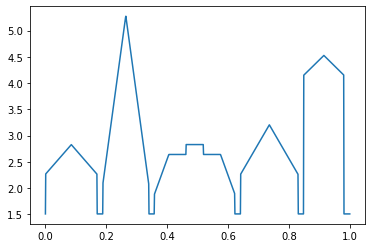

In [2]:
pts = [[0, 0.075444], [1e-07, 0.113166], [0.084874, 0.141457], [0.169748, 0.113166], 
       [0.1697481, 0.075444], [0.169748, 0.075444], [0.188609, 0.075444], [0.1886091, 0.103735],
       [0.264053, 0.264053], [0.339497, 0.103735], [0.3394971, 0.075444], [0.358358, 0.075444],
       [0.3583581, 0.094305], [0.40551, 0.132027], [0.462093, 0.132027], [0.4620931, 0.141457],
       [0.518676, 0.141457], [0.5186761, 0.132027], [0.575259, 0.132027], [0.622411, 0.094305],
       [0.6224111, 0.075444], [0.641272, 0.075444], [0.6412721, 0.113166], [0.735576, 0.160318],
       [0.829881, 0.113166], [0.8298811, 0.075444], [0.848742, 0.075444], [0.8487421, 0.20747],
       [0.914756, 0.226331], [0.980769, 0.20747], [0.9807691, 0.075444], [1.0, 0.075444]]

pre_pot = interp1d(np.array(pts)[:,0], np.array(pts)[:,1])

def potential(x):
    x = x % 1.
    return 20*pre_pot(x)

xl = np.linspace(0., 1., 1000)
plt.plot(xl, [potential(x) for x in xl])
plt.show()

Построим численно решения уравнения Шредингера $\psi_1^E(x)$, $\psi_2^E(x)$. Для этого воспользуемся функцией [`odeint` пакета `scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).
Для этого необходимо привести уравнение к системе уравнений первого порядка
$$
    \psi'(x) = \phi(x),\qquad
    \phi'(x) = \frac{2m}{\hbar^2}\bigl(V(x)-E\bigr) \, \phi(x).
$$
Координаты обезразмерим периодом $a$, а энергию &mdash; величиной $\frac{\hbar^2}{2m a^2}$.

In [3]:
def schr_rhs(y, x, E, pot):
    return [y[1], 2*(pot(x) - E)*y[0]]

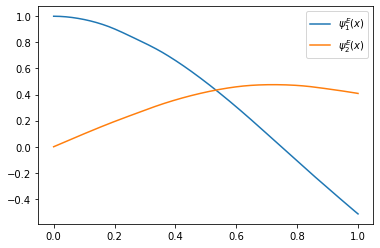

In [4]:
E = 5.

lp = np.linspace(0., 1., 200)
y1 = odeint(schr_rhs, [1, 0], lp, args=(E, potential))
y2 = odeint(schr_rhs, [0, 1], lp, args=(E, potential))

plt.plot(lp, y1[:,0], label="$\psi_1^E(x)$")
plt.plot(lp, y2[:,0], label="$\psi_2^E(x)$")
plt.legend()
plt.show()

Далее введём функции, вычисляющие $M(x, E)$ и $\gamma(E)$
$$
    M(x, E) = 
    \begin{pmatrix}
        \psi_1^E(x) & \psi_2^E(x) \\
        {\psi_1^E}'(x) & {\psi_2^E}'(x)
    \end{pmatrix}, \qquad \gamma(E) = \operatorname{tr}M(a,E).
$$

In [5]:
def matrix_M(E, pot):
    lp = np.linspace(0., 1., 1000)
    y1 = odeint(schr_rhs, [1, 0], lp, args=(E, pot))
    y2 = odeint(schr_rhs, [0, 1], lp, args=(E, pot))

    M = np.array([y1[-1], y2[-1]])
    return M

def gamma(E, pot):
    return 0.5*matrix_M(E, pot).trace()

Так как нет зон с энергией меньше минимума потенциала, введём функцию, вычисляющую этот минимум с помощью функции [`brute` пакета `scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html).

In [6]:
def pot_min(pot):
    return pot(brute(pot, [(0., 1.)]).min())

print(pot_min(potential))

1.50888


Построим функцию $\gamma(E)$, чтобы определить местоположение зон.

In [7]:
lE = np.linspace(pot_min(potential), 80., 200)
g_data = [gamma(E, potential) for E in lE]

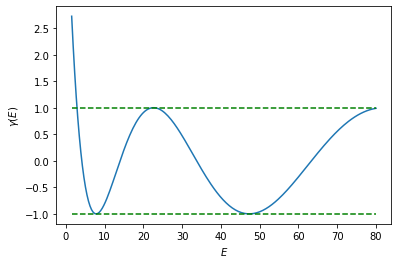

In [8]:
plt.plot(lE, g_data)
plt.plot([lE[0], lE[-1]], [1., 1.], c='g', ls='--')
plt.plot([lE[0], lE[-1]], [-1., -1.], c='g', ls='--')
plt.ylabel("$\gamma(E)$")
plt.xlabel("$E$")
plt.show()

# Задание

* Придумайте свой периодический потенциал (функцию `potential`). Физически аргумендируйте свой выбор:)
* Напишите функцию, задающую зависимость $E = E_n(\theta)$, т.е. зависимость энергии в $n$-ой зоне от фазы собственного значения оператора трансляции $\theta$.
* Постройте на одном графике $E_n(\theta)$ для нескольких первых зон для вашего потенциала, а также для потенциала свободной частицы. Для поиска корней уравнений и минимумов функций рекомендую использовать пакет [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html).